# CNN
***

## 概要  
人間の視覚の仕組みを取り入れ成功したモデルである。現在も広く使われており、その応用範囲はとても広い。画像認識、クラス分類、など画像が絡むタスクはだいたいCNNを用いて解決される. 

## 用語説明  
***
### CNN

畳込み層を用いるニューラルネットワークのこと。

### 画像

デジタル画像には、カラー画像とモノクロ(グレースケール)画像の二種類がある。カラー画像はRGBでピクセルを制御している。モノクロ画像は0~255の値で離散化して持つ

### 畳込み演算
画像など(一般にtensor)に対して、各要素ごとにフィルタを積和演算する演算のこと。以下の用語説明や、理論解説でも取り扱う。

![画像]()

### 畳込み層
畳込み演算を行う層を畳込み層と呼ぶ。英語ではConvolution Layer

### 局所受容野、カーネル、フィルター

説明する人の出身領域で言葉が変わってくるが本質的には同じものを指す。神経科学系なら局所受容野、画像系ならフィルター、その他はカーネルと呼んでいる人が多い気がする。今後、この資料ではフィルタでと呼ぶ。

### パディング

畳込みを行うと、tensorの大きさが小さくなるから、大きさを調整するために0などで画像の周囲を埋める

### ストライド

フィルタをどれだけ動かすか。通常は1

### 重み共有

### プーリング

図のような演算をプーリング(max pooling)という。

### プーリング層

プーリングを行う層をプーリング層という。この層を挟むことによって、フィルターの感度が鈍くなることになる。その結果、位置ずれに対する頑健性があがると言われている。一方で、特徴が失われるという否定的な意見もある。

## 理論解説
***
畳み込み演算とは、w h の大きさの画像に対してある画素$u_{ij}$に対して以下の操作を行うことを言う。


$$
u_{ij}=\sum_{p=0}^{H-1}\sum_{q=0}^{W-1}\,\it{x}_{i+p\, j+q}\,h_{pq}\hspace{2em}\tag{1}
$$

## 実装解説
***


In [1]:
!mkdir ../param

mkdir: ディレクトリ `../param' を作成できません: ファイルが存在します


In [1]:
# CNNの実装。MNISTの分類をする
# 必要ライブラリのインポート
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

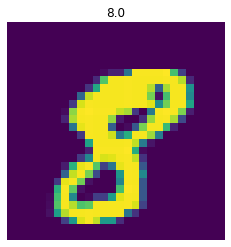

In [2]:
train = pd.read_csv(r"../input/digit-recognizer/train.csv", dtype=np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
# ラベル(0-9)
targets_numpy = train.label.values
# 画像データセット (784x1に伸ばされている)
features_numpy = train.loc[:, train.columns != "label"].values/255

# 訓練用とテスト用にデータセットを分割
features_train, features_test, targets_train, targets_test = train_test_split(
    features_numpy, targets_numpy, test_size=0.2, random_state=42)

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
# NumPy配列からTensorに変換
featuresTrain = torch.from_numpy(features_train)
featuresTrain = featuresTrain.reshape([-1 ,1 ,28, 28])
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
# NumPy配列からTensorに変換
featuresTest = torch.from_numpy(features_test)
featuresTest = featuresTest.reshape([-1, 1, 28, 28])
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
# バッチサイズとエポック数を決定
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
# 画像とラベルの組をデータセット に変換
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
# ミニバッチ用のデータローダーを作成
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
# 画像を可視化
plt.imshow(features_numpy[10].reshape(28, 28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [5]:
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.mlp = nn.Sequential(
            nn.Linear(64*4*4, 120),
            nn.ReLU(),
            nn.Linear(120, 10),
            nn.Softmax()
        )
        
        self.net = nn.Sequential(
            self.cnn,
            FlattenLayer(),
            self.mlp
        )
    def forward(self, x):
        return self.net(x)


In [6]:
# 評価用の関数
def eval_net(net, data_loader, device = 'cpu'):
    # DropputやBatchNorm を無効化する(評価時には必要ないから))
    net.eval()

    # 表示用の配列
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _, y_pred = torch.max(net(x), 1)
        ys.append(y)
        ypreds.append(y_pred)
        
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    
    acc = (ys == ypreds).float().sum() / len (ys)
    return acc.item()


# 訓練用の関数
def train_net(net, train_loader, test_loader,
             #optimizer = optim.Adam,
             loss_fn = nn.CrossEntropyLoss(),
             n_iter = 10, device = 'cpu'):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optim.Adam(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.
        net.train()
        n = 0
        n_acc = 0
        
        for i, (xx, yy) in tqdm(enumerate(train_loader), total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            # 勾配を初期化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = torch.max(h, 1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        
        train_acc.append(n_acc / n)
        
        val_acc.append(eval_net(net, test_loader, device))
        
        #学習結果をコンソールに表示
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
            


In [7]:
net = CNN()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net.to(device)
train_net(net, train_loader, test_loader, n_iter=20, device=device)

100%|██████████| 336/336 [00:01<00:00, 259.15it/s]
0 1.5139556393694522 0.9624404761904762 0.977142870426178
100%|██████████| 336/336 [00:01<00:00, 329.06it/s]1 1.48085010905764 0.9859523809523809 0.9847618937492371

100%|██████████| 336/336 [00:01<00:00, 334.01it/s]
2 1.4771150944837883 0.9888988095238095 0.9827380776405334
100%|██████████| 336/336 [00:01<00:00, 335.25it/s]
3 1.4744558800512286 0.9916369047619048 0.9861904382705688
100%|██████████| 336/336 [00:01<00:00, 331.56it/s]4 1.4724312558102963 0.9935416666666667 0.9870237708091736

100%|██████████| 336/336 [00:01<00:00, 334.81it/s]
5 1.4719304921022103 0.994077380952381 0.9882142543792725
100%|██████████| 336/336 [00:01<00:00, 334.11it/s]
6 1.4709484705284461 0.9949404761904762 0.9876190423965454
100%|██████████| 336/336 [00:01<00:00, 311.62it/s]
7 1.4715494479706037 0.9944047619047619 0.9877380728721619
100%|██████████| 336/336 [00:01<00:00, 312.14it/s]
8 1.4712781169521274 0.9944047619047619 0.9888095259666443
100%|█████████

In [8]:
torch.save(net.state_dict(), r'../param/parameter.prm')

In [9]:
# 検証用データセットを作成
test = pd.read_csv(r"../input/digit-recognizer/test.csv", dtype=np.float32)

# データを正規化し、Tensorを作る
features_test = test.values/255
features_test = torch.from_numpy(features_test)
features_test = features_test.reshape([-1, 1, 28, 28])
test = TensorDataset(features_test)

# データローダを作成
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [10]:
# 推論用の関数
def prediction(data_loader, device='cpu'):
    net.load_state_dict(torch.load(r'../param/parameter.prm'))
    net.eval()
    test_pred = torch.LongTensor()

    for i, images in enumerate(data_loader):
        # print(images[0].size())
        images = images[0].to(device)
        output = net(images)
        _, pred = output.cpu().data.max(1, keepdim=True)
        test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred

In [11]:
# 推論を行う
test_pred = prediction(test_loader, device=device)

# データの整形
out_df = pd.DataFrame(np.c_[np.arange(1, len(test)+1)[:,None],
    test_pred.numpy()], columns=['ImageId', 'Label'])

# 出力
out_df.head()
out_df.to_csv('submission.csv', index=False)

TODO
- [x] 学習結果を保存する
- [x] 保存した学習結果を読み込んで推論
- [x] 推論に用いた画像とラベルを表示する  
- [ ] 32\*32 -> 28\*28 に変更する

演習問題